In [14]:
import pandas as pd
import quandl
import datetime 


# 이전년도 주가를 검색해보자

start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# 애플주가를 가져와 보자, 애플의 티커 기호는 AAPL 이다
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)
type(apple)

pandas.core.frame.DataFrame

In [15]:
apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-04,102.61,105.368,102.00,105.35,67649387.0,0.0,1.0,99.136516,101.801154,98.547165,101.783763,67649387.0
2016-01-05,105.75,105.850,102.41,102.71,55790992.0,0.0,1.0,102.170223,102.266838,98.943286,99.233131,55790992.0
2016-01-06,100.56,102.370,99.87,100.70,68457388.0,0.0,1.0,97.155911,98.904640,96.489269,97.291172,68457388.0
2016-01-07,98.68,100.130,96.43,96.45,81094428.0,0.0,1.0,95.339552,96.740467,93.165717,93.185040,81094428.0
2016-01-08,98.55,99.110,96.76,96.96,70798016.0,0.0,1.0,95.213952,95.754996,93.484546,93.677776,70798016.0


Populating the interactive namespace from numpy and matplotlib


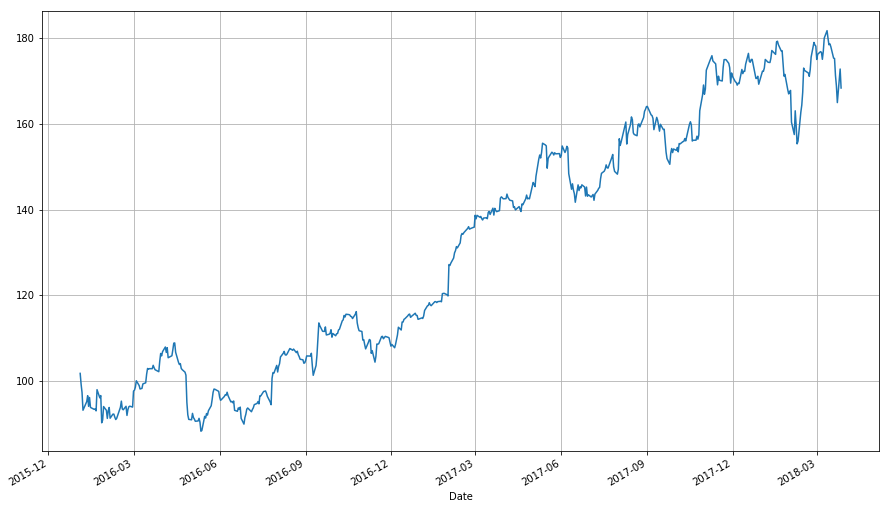

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (15,9)

apple["Adj. Close"].plot(grid = True)

## candlestick plot

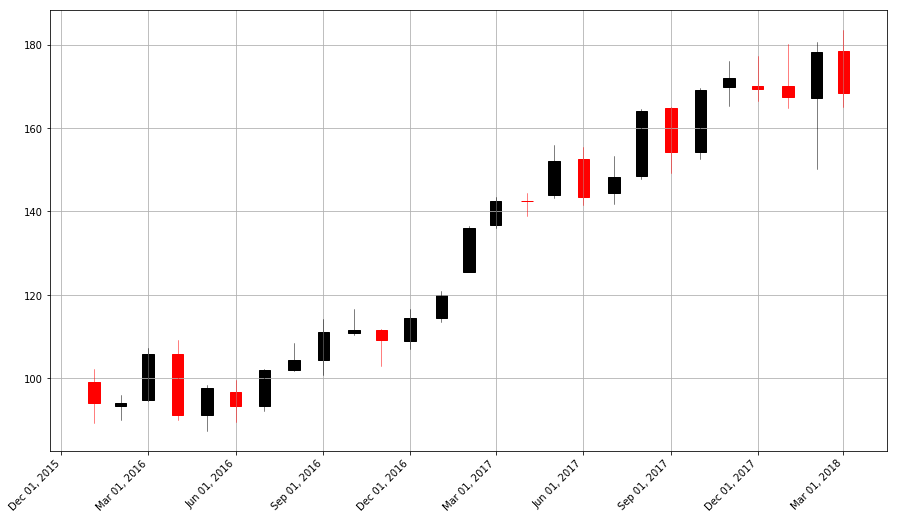

In [25]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns 
    "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. 
    Valid string inputs include "day", "week", "month", and "year", ("day" default), 
    and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple, adj=True, stick="month")

In [26]:
microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOG"])
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOG": google["Adj. Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,101.783763,741.84,52.181598
2016-01-05,99.233131,742.58,52.419653
2016-01-06,97.291172,743.62,51.467434
2016-01-07,93.185040,726.39,49.677262
2016-01-08,93.677776,714.47,49.829617


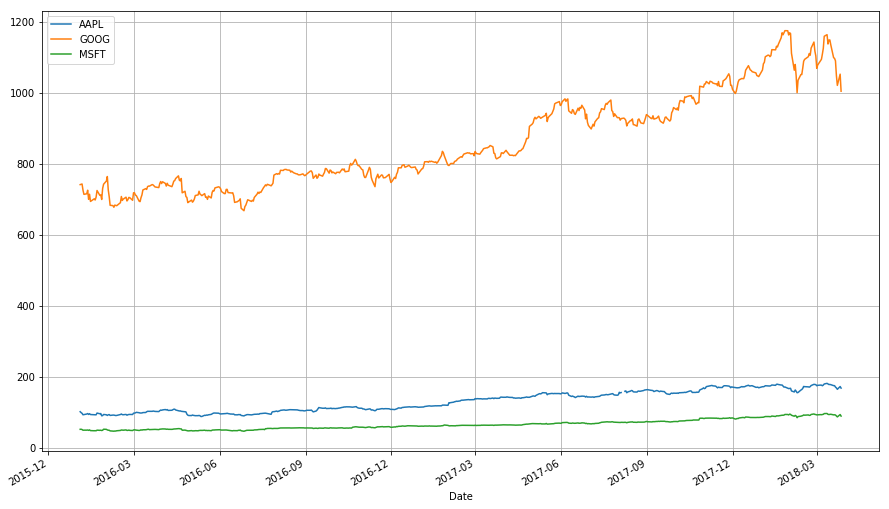

In [27]:
stocks.plot(grid = True)

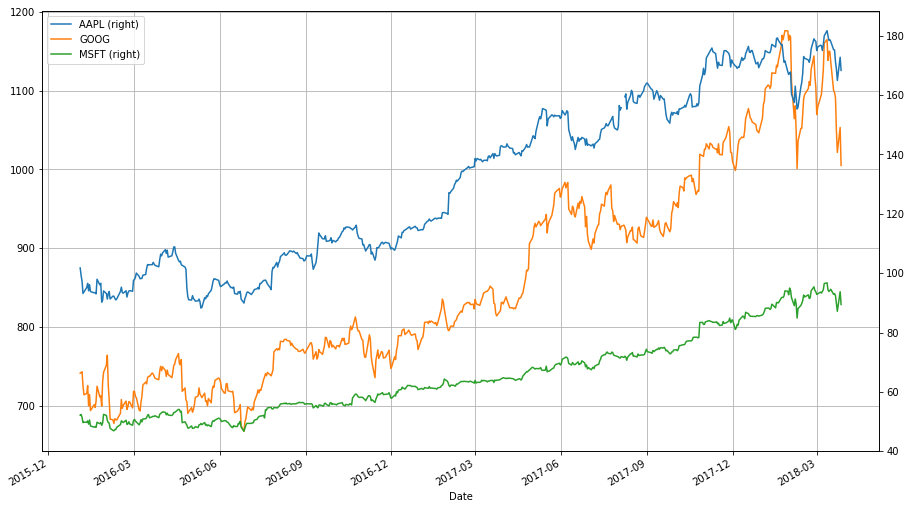

In [28]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [33]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,0.000000,0.000000,0.000000
2016-01-05,-0.025059,0.000998,0.004562
2016-01-06,-0.044139,0.002399,-0.013686
2016-01-07,-0.084480,-0.020827,-0.047993
2016-01-08,-0.079639,-0.036895,-0.045073


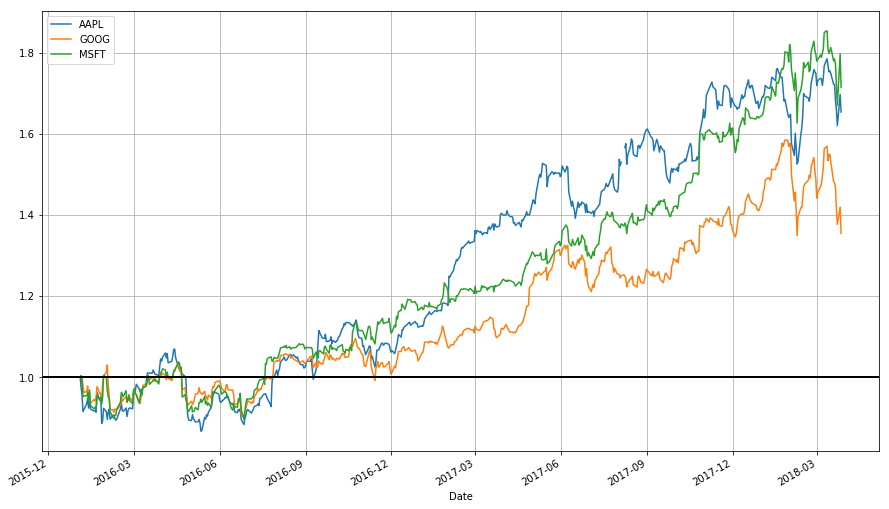

In [34]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [35]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


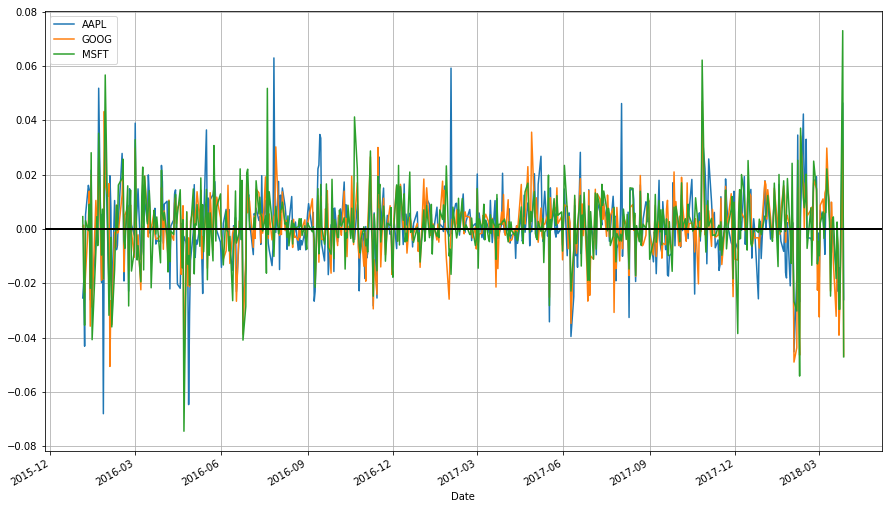

In [36]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

In [38]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

,AAPL,GOOG,MSFT
Date,,,
2018-03-21,-577.463148,-157.285338,-176.499833
2018-03-22,-359.355133,-984.592233,-743.873619
2018-03-23,-589.663945,-669.637836,-743.366326
2018-03-26,1168.762361,768.649993,1839.012005
2018-03-27,-654.582257,-1178.241231,-1185.615651


In [42]:
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

# Treasury Bills : 재정증권
"""
국가 또는 지방자치단체가 재정상의 수입을 목적으로 발행하는 유가증권을 말한다. 재정증권은 발행 주체가 국가 또는 지방자치단체라는 점에서 주식회사가 자금 조달을 위해 발행하는 사채(社債)와 다르고, 발행목적이 공익성을 띠고 있다는 점에서 사채(私債)와 다르다. 재정증권은 발행 주체에 따라 국채와 지방채로 구분할 수 있다. 이러한 재정증권으로는 건국국채, 산업부흥국채, 전화공채(電話公債) 등이 있다.
[네이버 지식백과] 재정증권 [財政證券, treasury bills] (행정학사전, 2009. 1. 15., 이종수)
"""

,Value
Date,
2019-01-01,2.37
2019-02-01,2.39
2019-03-01,2.40
2019-04-01,2.38
2019-05-01,2.35


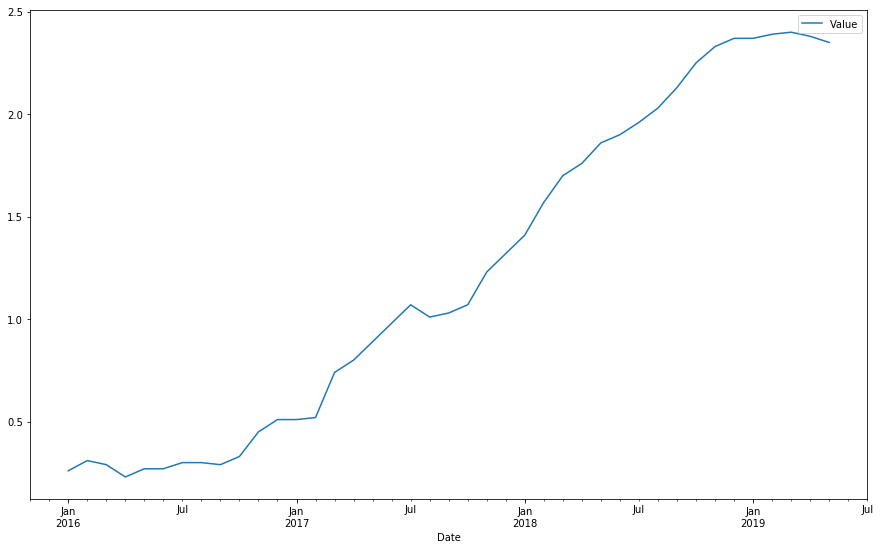

In [43]:
tbill.plot()

In [44]:
rrf = tbill.iloc[-1,0] # get the most recent Treasury Bill rate
rrf

2.35

In [53]:
#pandas.corrwith : 상관관계 계산
#애플주가와 다른것들의 상관관계 구하기 

In [54]:
smcorr = stock_change_apr.corrwith(stock_change_apr.AAPL)    
smcorr


AAPL    1.000000
GOOG    0.531819
MSFT    0.532177
dtype: float64

In [55]:
sy = stock_change_apr.drop("AAPL",1).std()
#std() : 거래 표준편차
sx = stock_change_apr.AAPL.std()

In [56]:
sy

GOOG    312.319468
MSFT    329.308164
dtype: float64

In [58]:
sx

339.92178239271556

In [67]:
import pandas_datareader.data as web
spyder = web.DataReader("SPY", "yahoo", start, end) 


spyder = spyder.loc[start:end]
 
stocks = stocks.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})
stocks.head()

,AAPL,GOOG,MSFT,SPY
Date,,,,
2016-01-04,101.783763,741.84,52.181598,187.698959
2016-01-05,99.233131,742.58,52.419653,188.016418
2016-01-06,97.291172,743.62,51.467434,185.644699
2016-01-07,93.185040,726.39,49.677262,181.190811
2016-01-08,93.677776,714.47,49.829617,179.201935


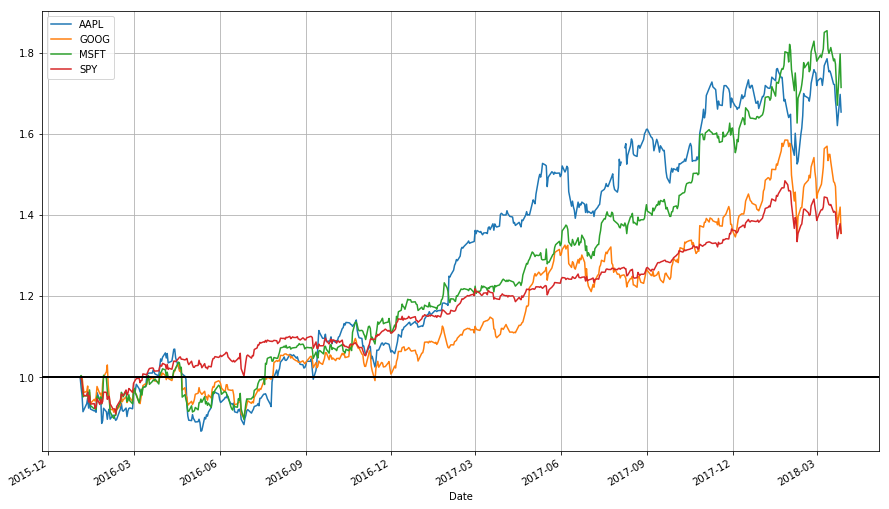

In [68]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

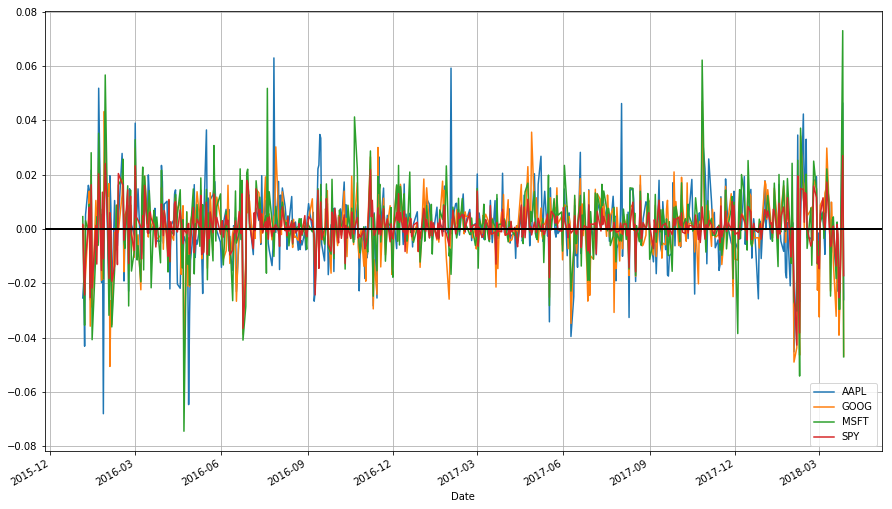

In [69]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid=True).axhline(y = 0, color = "black", lw = 2)

In [70]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

,AAPL,GOOG,MSFT,SPY
Date,,,,
2018-03-21,-577.463148,-157.285338,-176.499833,-48.409113
2018-03-22,-359.355133,-984.592233,-743.873619,-637.939072
2018-03-23,-589.663945,-669.637836,-743.366326,-542.934191
2018-03-26,1168.762361,768.649993,1839.012005,680.186680
2018-03-27,-654.582257,-1178.241231,-1185.615651,-432.385845


In [71]:
smcorr = stock_change_apr.drop("SPY", 1).corrwith(stock_change_apr.SPY)    # Since RRF is constant it doesn't change the
                                                                           # correlation so we can ignore it in our
                                                                           # calculation
smcorr

AAPL    0.592219
GOOG    0.672283
MSFT    0.722942
dtype: float64

In [72]:
sy = stock_change_apr.drop("SPY", 1).std()
sx = stock_change_apr.SPY.std()
sy

AAPL    339.921782
GOOG    312.319468
MSFT    329.308164
dtype: float64

In [73]:
sx

187.30770467988415

In [74]:
ybar = stock_change_apr.drop("SPY", 1).mean() - rrf
xbar = stock_change_apr.SPY.mean() - rrf
ybar

AAPL    19.319035
GOOG    11.316893
MSFT    21.912806
dtype: float64

In [75]:
xbar

11.333637070848575

In [76]:
beta = smcorr * sy / sx
alpha = ybar - beta * xbar
beta

AAPL    1.074745
GOOG    1.120974
MSFT    1.271014
dtype: float64

In [77]:
alpha

AAPL    7.138264
GOOG   -1.387818
MSFT    7.507598
dtype: float64

# Sharpe ratio

특정 펀드가 한 단위의 위험자산에 투자해서 얻은 초과수익의 정도를 나타내는 지표이다. 샤프척도(Sharpe measure)라고도 하며, 트레이너지수(Treynor ratio)·젠센지수(Jensen's ratio)와 함께 위험을 감안하여 펀드를 측정하는 방법으로, 두 지수와 더불어 위험조정 후 수익률지수로 통칭된다. 1990년 노벨경제학상을 받은 미국의 윌리엄 샤프(William F.Sharpe)가 1954년부터 1963년까지 34개 펀드의 실적을 분석하여 개발하였다.

트레이너지수가 펀드의 베타계수만을 고려하는 반면 전체위험을 고려하는 표준편차를 사용하고, 최소 1개월 이상의 수익률 데이터를 필요로 한다. 분산투자가 잘 되어 있지 않은 펀드를 평가할 때 유용한 방법으로, 값이 높을수록 펀드의 수익률이 우수하다는 것을 보여준다.
[네이버 지식백과] 샤프지수 [Sharpe ratio] (두산백과)

In [78]:
sharpe = (ybar - rrf)/sy
sharpe

AAPL    0.049920
GOOG    0.028711
MSFT    0.059406
dtype: float64

In [79]:
(xbar - rrf)/sx

0.04796191959215957

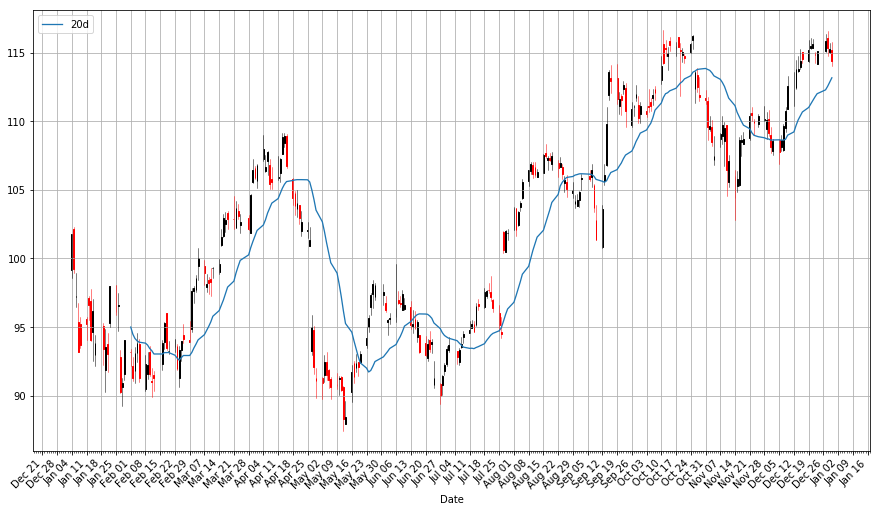

In [80]:
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)


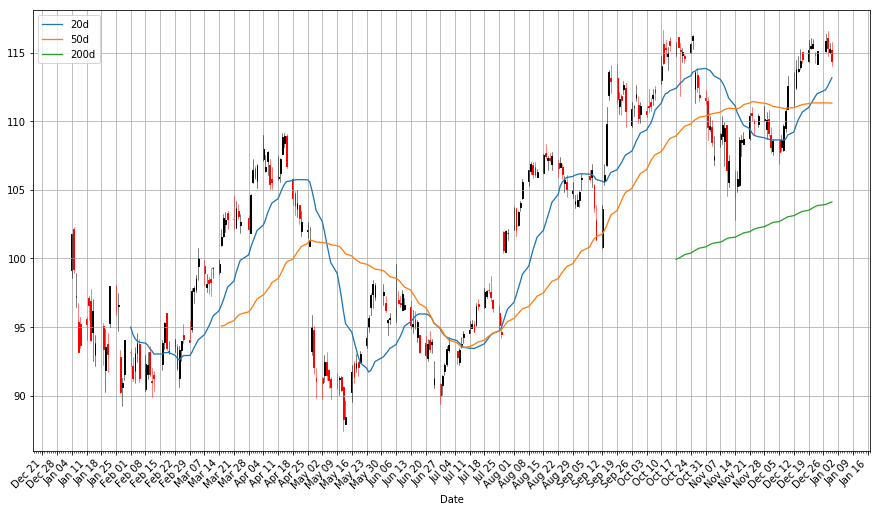

In [81]:
apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj. Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)


# Trading Strategy

In [85]:
apple['20d-50d'] = apple['20d'] - apple['50d']

apple.tail()

Date
2016-01-04     NaN
2016-01-05     NaN
2016-01-06     NaN
2016-01-07     NaN
2016-01-08     NaN
2016-01-11     NaN
2016-01-12     NaN
2016-01-13     NaN
2016-01-14     NaN
2016-01-15     NaN
2016-01-19     NaN
2016-01-20     NaN
2016-01-21     NaN
2016-01-22     NaN
2016-01-25     NaN
2016-01-26     NaN
2016-01-27     NaN
2016-01-28     NaN
2016-01-29     NaN
2016-02-01     NaN
2016-02-02     NaN
2016-02-03     NaN
2016-02-04     NaN
2016-02-05     NaN
2016-02-08     NaN
2016-02-09     NaN
2016-02-10     NaN
2016-02-11     NaN
2016-02-12     NaN
2016-02-16     NaN
              ... 
2018-02-13   -2.94
2018-02-14   -3.46
2018-02-15   -3.83
2018-02-16   -4.19
2018-02-20   -4.50
2018-02-21   -4.84
2018-02-22   -4.98
2018-02-23   -4.82
2018-02-26   -4.58
2018-02-27   -4.19
2018-02-28   -3.74
2018-03-01   -3.40
2018-03-02   -2.96
2018-03-05   -2.19
2018-03-06   -1.27
2018-03-07   -0.67
2018-03-08    0.16
2018-03-09    1.20
2018-03-12    2.27
2018-03-13    2.95
2018-03-14    3.47
2018-03

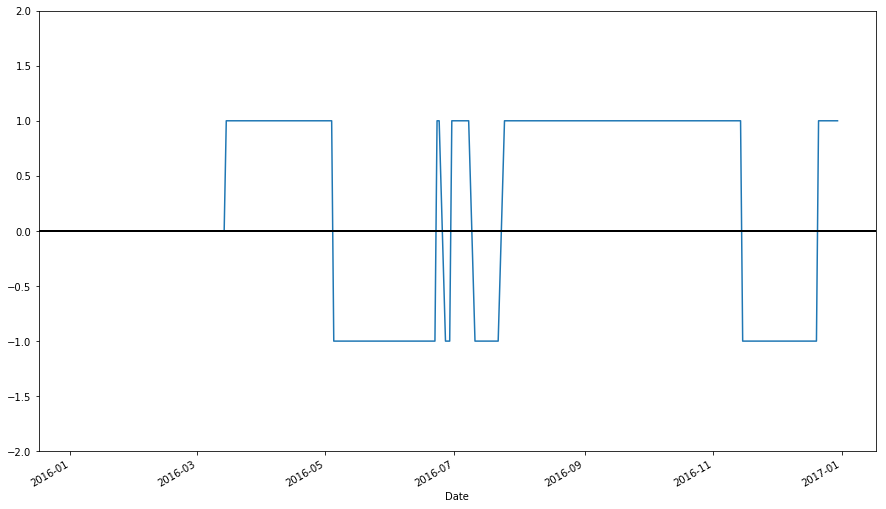

In [84]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [90]:
# np.where()  : 조건에 해당하는 색인(index) 값을 찾기

x = np.array([1,2,3,4,5,6])
a = np.where(x > 3 , 1 , 0)
a

array([0, 0, 0, 1, 1, 1])

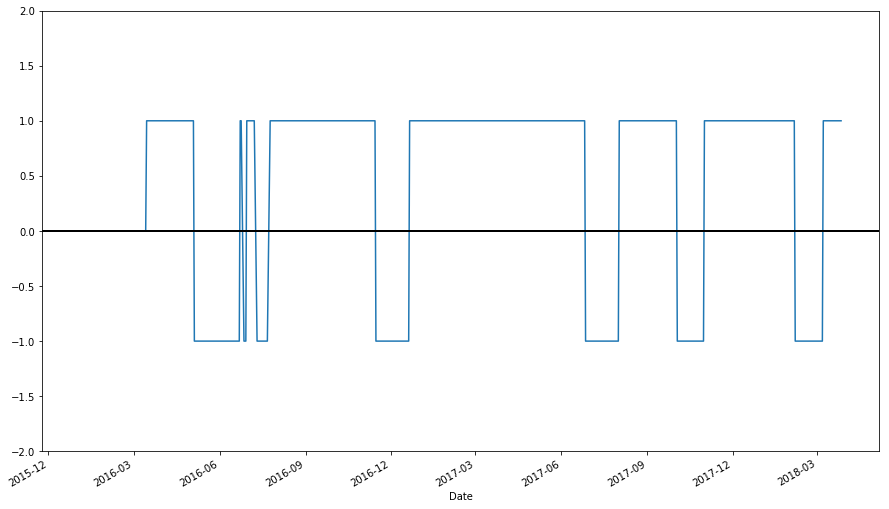

In [86]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [87]:
apple["Regime"].value_counts()

 1    372
-1    139
 0     49
Name: Regime, dtype: int64

In [88]:
apple["Regime"]

Date
2016-01-04    0
2016-01-05    0
2016-01-06    0
2016-01-07    0
2016-01-08    0
2016-01-11    0
2016-01-12    0
2016-01-13    0
2016-01-14    0
2016-01-15    0
2016-01-19    0
2016-01-20    0
2016-01-21    0
2016-01-22    0
2016-01-25    0
2016-01-26    0
2016-01-27    0
2016-01-28    0
2016-01-29    0
2016-02-01    0
2016-02-02    0
2016-02-03    0
2016-02-04    0
2016-02-05    0
2016-02-08    0
2016-02-09    0
2016-02-10    0
2016-02-11    0
2016-02-12    0
2016-02-16    0
             ..
2018-02-13   -1
2018-02-14   -1
2018-02-15   -1
2018-02-16   -1
2018-02-20   -1
2018-02-21   -1
2018-02-22   -1
2018-02-23   -1
2018-02-26   -1
2018-02-27   -1
2018-02-28   -1
2018-03-01   -1
2018-03-02   -1
2018-03-05   -1
2018-03-06   -1
2018-03-07   -1
2018-03-08    1
2018-03-09    1
2018-03-12    1
2018-03-13    1
2018-03-14    1
2018-03-15    1
2018-03-16    1
2018-03-19    1
2018-03-20    1
2018-03-21    1
2018-03-22    1
2018-03-23    1
2018-03-26    1
2018-03-27    1
Name: Regime, Lengt

- -1 은 매도를 나타낸다.
-  1 은 매수를 나타낸다
-  0 은 no action 이다

In [91]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

D:\user\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\user\envs\py35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sign
  after removing the cwd from sys.path.


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37,1,0.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30,1,0.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96,1,0.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70,1,0.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36,1,-1.0


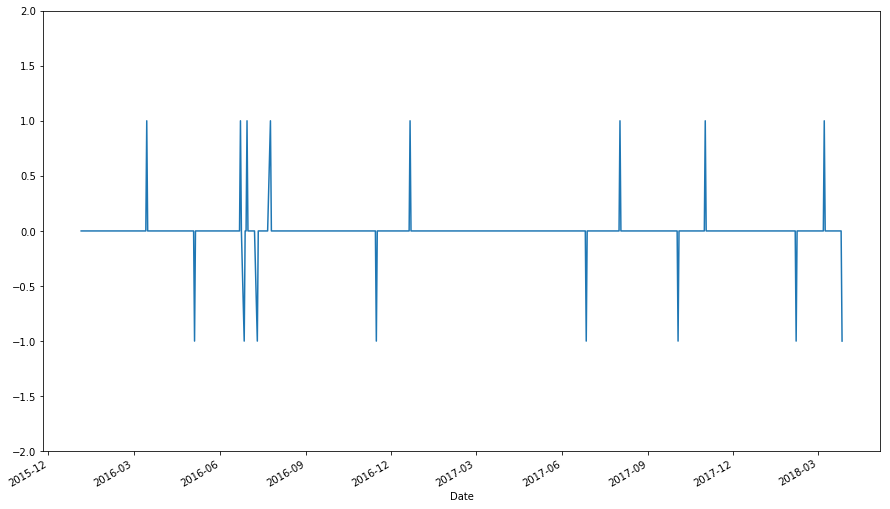

In [103]:
apple["Signal"].plot(ylim = (-2, 2))

In [105]:
apple["Signal"].value_counts()

 0.0    543
-1.0      8
 1.0      8
Name: Signal, dtype: int64

In [106]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2016-03-15    104.58
2016-06-23     96.10
2016-06-30     95.60
2016-07-25     97.34
2016-12-21    117.06
2017-08-02    157.14
2017-11-01    166.89
2018-03-08    176.94
Name: Close, dtype: float64

In [107]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2016-05-05     93.24
2016-06-27     92.04
2016-07-11     96.98
2016-11-15    107.11
2017-06-27    143.74
2017-10-03    154.48
2018-02-06    163.03
2018-03-27    168.34
Name: Close, dtype: float64

In [109]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2016-03-15,101.583729,1,Buy
2016-05-05,91.122295,-1,Sell
2016-06-23,93.917337,1,Buy
2016-06-27,89.949550,-1,Sell
2016-06-30,93.428693,1,Buy
2016-07-11,94.777350,-1,Sell
2016-07-25,95.129174,1,Buy
2016-11-15,105.787035,-1,Sell
2016-12-21,115.614138,1,Buy


자 그러면 우리가 정한 룰(아래)에 따라 이제 백만달러를 가지고 시뮬레이션을 돌려보도록 하자 .

- 모든 투자는 포트폴리오의 10퍼센트로만 한다
- 거래가치의 20퍼센트 이상의 하락이면 손절 한다.

In [111]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2016-03-15,2016-05-05,101.583729,-10.461434
2016-06-23,2016-06-27,93.917337,-3.967788
2016-06-30,2016-07-11,93.428693,1.348657
2016-07-25,2016-11-15,95.129174,10.657861
2016-12-21,2017-06-27,115.614138,27.545001
2017-08-02,2017-10-03,156.504989,-2.024989
2017-11-01,2018-02-06,166.890000,-3.860000
2018-03-08,2018-03-27,176.940000,-8.600000


In [112]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

,End Date,Price,Profit,Low
Date,,,,
2016-03-15,2016-05-05,101.583729,-10.461434,89.752692
2016-06-23,2016-06-27,93.917337,-3.967788,89.421814
2016-06-30,2016-07-11,93.428693,1.348657,92.158220
2016-07-25,2016-11-15,95.129174,10.657861,94.230069
2016-12-21,2017-06-27,115.614138,27.545001,113.342546
2017-08-02,2017-10-03,156.504989,-2.024989,149.160000
2017-11-01,2018-02-06,166.890000,-3.860000,154.000000
2018-03-08,2018-03-27,176.940000,-8.600000,164.940000


In [115]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .05    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2016-03-15,2016-05-05,1.086850e+06,96.500000,101.583729,900.0,1.000000e+06,1.0,86850.000000,91425.355735
2016-06-23,2016-06-27,1.082485e+06,-3.967788,93.917337,1100.0,1.086850e+06,0.0,-4364.566368,103309.070918
2016-06-30,2016-07-11,1.083969e+06,1.348657,93.428693,1100.0,1.082485e+06,0.0,1483.522558,102771.562745
2016-07-25,2016-11-15,1.095693e+06,10.657861,95.129174,1100.0,1.083969e+06,0.0,11723.647322,104642.091188
2016-12-21,2017-06-27,1.120483e+06,27.545001,115.614138,900.0,1.095693e+06,0.0,24790.501098,104052.724175
2017-08-02,2017-10-03,1.119066e+06,-2.024989,156.504989,700.0,1.120483e+06,0.0,-1417.492367,109553.492367
2017-11-01,2018-02-06,1.214196e+06,158.550000,166.890000,600.0,1.119066e+06,1.0,95130.000000,100134.000000
2018-03-08,2018-03-27,1.315050e+06,168.090000,176.940000,600.0,1.214196e+06,1.0,100854.000000,106164.000000


이렇게 투자하면 망한다....

논문에선 16퍼정도의 수익이 발생하는데 내꺼에선 ,, 뭐가 잘 못 됬는지 거래도 적고 ㅎㅎㅎ 

손절점을 20퍼에 5퍼로 내렸을떈 수익이 훨씬 향상되긴 했다..

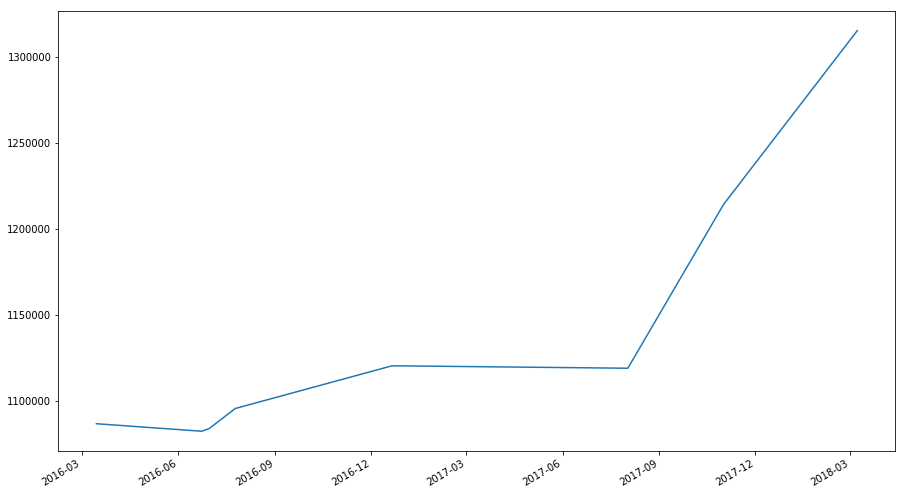

In [117]:
apple_backtest["End Port. Value"].plot()

In [119]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
(microsoft, google, facebook, twitter, netflix,amazon, yahoo, ge, qualcomm, ibm, hp) = (quandl.get("WIKI/" + s, start_date=start,end_date=end) for s in ["MSFT", "GOOG", "FB", "TWTR","NFLX", "AMZN", "YHOO", "GE", "QCOM", "IBM", "HPQ"])

In [120]:
signals = ma_crossover_orders([("AAPL", apple),
                              ("MSFT",  microsoft),
                              ("GOOG",  google),
                              ("FB",    facebook),
                              ("TWTR",  twitter),
                              ("NFLX",  netflix),
                              ("AMZN",  amazon),
                              ("YHOO",  yahoo),
                              ("GE",    ge),
                              ("QCOM",  qualcomm),
                              ("IBM",   ibm),
                              ("HPQ",   hp)],
                            fast = 20, slow = 50)
signals

D:\user\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\user\envs\py35\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sign


Price  Regime Signal
Date       Symbol                            
2016-03-15 AAPL     101.583729     1.0    Buy
           AMZN     577.020000    -1.0   Sell
           FB       110.670000     1.0    Buy
           GE        28.835073     1.0    Buy
           GOOG     728.330000    -1.0   Sell
           HPQ       10.862855     1.0    Buy
           IBM      133.943742     1.0    Buy
           MSFT      51.388986     1.0    Buy
           NFLX      97.860000    -1.0   Sell
           QCOM      48.419793     1.0    Buy
           TWTR      16.190000     1.0    Buy
           YHOO      33.260000     1.0    Buy
2016-03-17 AMZN     559.440000     1.0    Buy
           GOOG     737.780000     1.0    Buy
2016-03-21 NFLX     101.060000     1.0    Buy
2016-04-01 TWTR      15.980000    -1.0   Sell
2016-04-28 QCOM      48.888705    -1.0   Sell
2016-05-04 MSFT      47.821771    -1.0   Sell
           NFLX      90.790000    -1.0   Sell
2016-05-05 AAPL      91.122295    -1.0   Sell
           GOOG     701.430000    -1.0   Sell
           QCOM      47.950882     1.0    Buy
2016-05-10 GE        29.025529    -1.0   Sell
2016-05-17 HPQ       10.986729    -1.0   Sell
2016-05-18 IBM      139.359652    -1.0   Sell
2016-06-02 IBM      145.186010     1.0    Buy
2016-06-07 HPQ       13.044955     1.0    Buy
2016-06-14 NFLX      94.120000     1.0    Buy
2016-06-23 GE        29.924605     0.0    Buy
           TWTR      17.040000     1.0    Buy
...                        ...     ...    ...
2017-11-01 AAPL     166.890000     1.0    Buy
2017-12-06 NFLX     185.300000    -1.0   Sell
2017-12-15 HPQ       20.920000    -1.0   Sell
2017-12-26 FB       175.990000    -1.0   Sell
2018-01-03 FB       184.670000     1.0    Buy
2018-01-09 NFLX     209.310000     1.0    Buy
2018-01-11 HPQ       22.410000     1.0    Buy
2018-01-18 QCOM      68.050000    -1.0   Sell
2018-01-19 QCOM      68.040000     1.0    Buy
2018-02-06 AAPL     163.030000    -1.0   Sell
2018-02-21 IBM      153.960000    -1.0   Sell
           QCOM      63.400000    -1.0   Sell
2018-02-22 HPQ       21.390000    -1.0   Sell
2018-02-23 FB       183.290000    -1.0   Sell
2018-02-27 GOOG    1118.290000    -1.0   Sell
2018-03-08 AAPL     176.940000     1.0    Buy
2018-03-09 HPQ       24.650000     1.0    Buy
2018-03-14 GOOG    1149.490000     1.0    Buy
2018-03-23 GOOG    1021.570000    -1.0   Sell
2018-03-27 AAPL     168.340000     1.0   Sell
           AMZN    1497.050000     1.0   Sell
           FB       152.190000    -1.0    Buy
           GE        13.440000    -1.0    Buy
           GOOG    1005.100000    -1.0    Buy
           HPQ       21.770000     1.0   Sell
           IBM      151.910000    -1.0    Buy
           MSFT      89.470000     1.0   Sell
           NFLX     300.690000     1.0   Sell
           QCOM      54.840000    -1.0    Buy
           TWTR      28.070000     1.0   Sell

[139 rows x 3 columns]

In [121]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2016-03-15 AAPL    9.085746e+05     1.000000e+06          0.000000   
           AMZN    9.085746e+05     1.000000e+06          0.000000   
           FB      8.089716e+05     1.000000e+06          0.000000   
           GE      7.109324e+05     1.000000e+06          0.000000   
           GOOG    7.109324e+05     1.000000e+06          0.000000   
           HPQ     6.120804e+05     1.000000e+06          0.000000   
           IBM     5.183198e+05     1.000000e+06          0.000000   
           MSFT    4.206807e+05     1.000000e+06          0.000000   
           NFLX    4.206807e+05     1.000000e+06          0.000000   
           QCOM    3.238411e+05     1.000000e+06          0.000000   
           TWTR    2.250821e+05     1.000000e+06          0.000000   
           YHOO    1.253021e+05     1.000000e+06          0.000000   
2016-03-17 AMZN    6.935814e+04     1.000000e+06          0.000000   
           GOOG   -4.419861e+03     1.000000e+06          0.000000   
2016-03-21 NFLX   -9.537386e+04     1.000000e+06          0.000000   
2016-04-01 TWTR    2.104139e+03     9.987190e+05         -0.210000   
2016-04-28 QCOM    9.988155e+04     9.996568e+05          0.468911   
2016-05-04 MSFT    1.907429e+05     9.928791e+05         -3.567215   
           NFLX    2.724539e+05     9.836361e+05        -10.270000   
2016-05-05 AAPL    3.544640e+05     9.742208e+05        -10.461434   
           GOOG    4.246070e+05     9.705858e+05        -36.350000   
           QCOM    3.287052e+05     9.705858e+05          0.000000   
2016-05-10 GE      4.273920e+05     9.712334e+05          0.190456   
2016-05-17 HPQ     5.273713e+05     9.723606e+05          0.123875   
2016-05-18 IBM     6.249230e+05     9.761518e+05          5.415910   
2016-06-02 IBM     5.378114e+05     9.761518e+05          0.000000   
2016-06-07 HPQ     4.412787e+05     9.761518e+05          0.000000   
2016-06-14 NFLX    3.471587e+05     9.761518e+05          0.000000   
2016-06-23 GE      3.471587e+05     9.761518e+05          1.089532   
           TWTR    2.500307e+05     9.761518e+05          0.000000   
...                         ...              ...               ...   
2017-11-01 AAPL    1.009343e+05     1.152171e+06          0.000000   
2017-12-06 NFLX    2.121143e+05     1.150227e+06         -3.240000   
2017-12-15 HPQ     3.376343e+05     1.161269e+06          1.840267   
2017-12-26 FB      4.784263e+05     1.200765e+06         49.370000   
2018-01-03 FB      3.676243e+05     1.200765e+06          0.000000   
2018-01-09 NFLX    2.629693e+05     1.200765e+06          0.000000   
2018-01-11 HPQ     1.441963e+05     1.200765e+06          0.000000   
2018-01-18 QCOM    2.871013e+05     1.230957e+06         14.377402   
2018-01-19 QCOM    1.646293e+05     1.230957e+06          0.000000   
2018-02-06 AAPL    2.624473e+05     1.228641e+06         -3.860000   
2018-02-21 IBM     3.702193e+05     1.234835e+06          8.848221   
           QCOM    4.843393e+05     1.226483e+06         -4.640000   
2018-02-22 HPQ     5.977063e+05     1.221077e+06         -1.020000   
2018-02-23 FB      7.076803e+05     1.220249e+06         -1.380000   
2018-02-27 GOOG    8.195093e+05     1.237128e+06        168.790000   
2018-03-08 AAPL    7.133453e+05     1.237128e+06          0.000000   
2018-03-09 HPQ     5.900953e+05     1.237128e+06          0.000000   
2018-03-14 GOOG    4.751463e+05     1.237128e+06          0.000000   
2018-03-23 GOOG    5.773033e+05     1.224336e+06       -127.920000   
2018-03-27 AAPL    6.783073e+05     1.219176e+06         -8.600000   
           AMZN    8.280123e+05     1.268247e+06        490.710000   
           FB      8.280123e+05     1.268247e+06        -32.480000   
           GE      8.280123e+05     1.268247e+06        -16.213194   
           GOOG    8.280123e+05     1.268247e+06       -144.390000   
           HPQ     9.368623e+05  

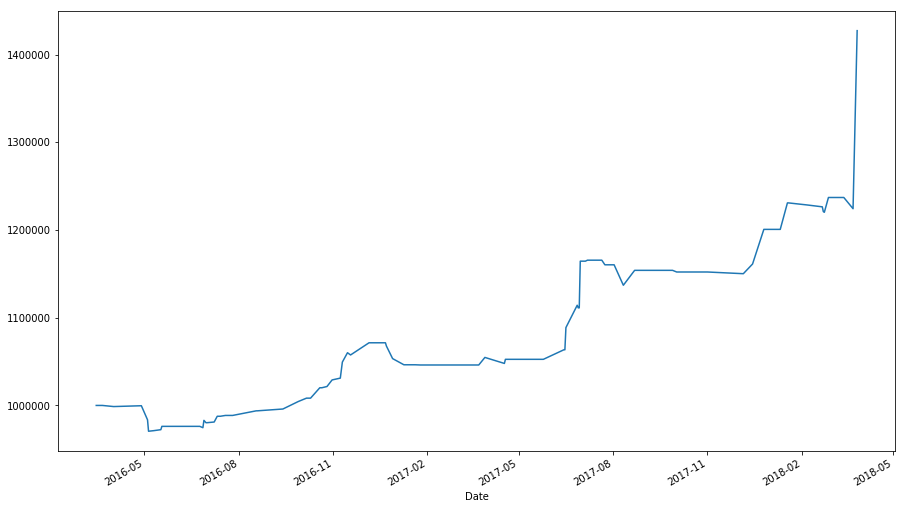

In [122]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()
